In [2]:
# ECG Signal Classification using a Custom CNN (Apnea Detection)
#
# This notebook tests a custom 1D CNN on ECG signal data. It performs the following:
# 1. Loads and normalizes training and test ECG signals.
# 2. Splits the data into training and validation sets.
# 3. Defines a custom 1D CNN architecture for binary classification.
# 4. Trains the model using Ignite with progress bars, early stopping, and learning rate scheduling.
# 5. Evaluates the model on a test set and computes various metrics.
# 6. Optimizes decision thresholds using ROC and Precision-Recall curves.
#
# Note: Update file paths as needed.

In [3]:
import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
from torchvision import models

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             hamming_loss, ConfusionMatrixDisplay, 
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

import neurokit2 as nk

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Ignite imports for training loop management
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")


In [4]:
# Data Loading and Normalization (Raw data can be generated from the raw_data_generating jupyter notebook)
# Load training ECG signals and labels (assumes numpy arrays are saved at these paths)
ECG_signal_train = np.load(r"C:\Users\piotr\Downloads\training_signal.npy")
ECG_labels_train = np.load(r"C:\Users\piotr\Downloads\training labels.npy")

def z_score_normalization(ecg_signal):
    """Normalize an ECG signal using Z-score normalization."""
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal) + 1e-8  # Avoid division by zero
    return (ecg_signal - mean) / std

# Normalize each ECG signal in the training set
for i in range(len(ECG_signal_train)):
    ECG_signal_train[i] = z_score_normalization(ECG_signal_train[i])

# Split data into training and validation sets
data_train, data_val, label_train, label_val = train_test_split(ECG_signal_train, ECG_labels_train)


In [5]:
# Custom Dataset Definition
class My1DDataset(Dataset):
    def __init__(self, data, labels):
        if isinstance(data, np.ndarray):
            data = torch.tensor(data, dtype=torch.float32)
        if data.ndim == 2:
            data = data.unsqueeze(1)  # Add channel dimension
        self.data = data.to(device) if device else data
        self.labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
        if device:
            self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [6]:
# CNN Model Definition
class CNNBlock(nn.Module):
    """
    A basic 1D CNN block: Conv1d -> BatchNorm1d -> ReLU -> MaxPool1d -> Dropout.
    """
    def __init__(self, in_channels, out_channels, kernel_size=32):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding='same')
        self.bn = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x))) 
        x = self.pool(x) 
        x = self.dropout(x)  
        return x
class ApneaCNN(nn.Module):
    """
    CNN model for apnea detection on ECG signals.
    Architecture: 10 CNN blocks followed by fully connected layers.
    """
    def __init__(self, input_channels=1, input_length=12000):
        super(ApneaCNN, self).__init__()

        # Feature Extraction: 10 CNN layers
        self.conv_layers = nn.Sequential(
            CNNBlock(input_channels, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45),
            CNNBlock(45, 45)
        )


        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(11*45, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 1),  # Output: Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [7]:
# Setup Training Environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ApneaCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Create datasets and dataloaders for training and validation
train_dataset = My1DDataset(data_train, label_train)
val_dataset = My1DDataset(data_val, label_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [8]:
# Create a supervised trainer using Ignite
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

# Function to threshold outputs for evaluation (sigmoid then round)
def thresholded_output_transform(output):
    y_pred, y = output
    y_pred = torch.round(torch.sigmoid(y_pred))
    return y_pred, y

# Define evaluation metrics
val_metrics = {
    "accuracy": Accuracy(output_transform=thresholded_output_transform),
    "precision": Precision(output_transform=thresholded_output_transform),
    "recall": Recall(output_transform=thresholded_output_transform),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach a progress bar
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})


In [9]:
# Ignite Event Handlers

@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"\nValidation - Epoch: {engine.state.epoch} | "
          f"Avg accuracy: {avg_accuracy:.4f} | Avg loss: {avg_loss:.4f}")
@trainer.on(Events.EPOCH_COMPLETED)
def log_learning_rate(engine):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after Epoch {engine.state.epoch}: {current_lr:.6f}")
@trainer.on(Events.EPOCH_COMPLETED)
def run_scheduler(engine):
    val_loss = val_evaluator.state.metrics["loss"]
    scheduler.step(val_loss)
    print(f"Scheduler stepped with validation loss: {val_loss:.4f}")
    
early_stopping = EarlyStopping(
    patience=10,  # Number of epochs to wait without improvement
    score_function=lambda engine: -engine.state.metrics["loss"],  # Use validation loss (negative for minimizing)
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

checkpoint_handler = ModelCheckpoint(
    dirname='checkpoints',
    filename_prefix='chestxray',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    score_function=lambda e: -e.state.metrics["loss"], 
    score_name="val_loss",
    global_step_transform=lambda e, _: e.state.epoch
)

val_evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {
    'best_model': model
})

In [ ]:
# Run training for a maximum of 1000 epochs. The early stopping will kick in around 37 epochs.
trainer.run(train_loader, max_epochs=1000)

[1/772]   0%|           [00:00<?]


Validation - Epoch: 1 | Avg accuracy: 0.8274 | Avg loss: 0.3880
Learning Rate after Epoch 1: 0.001000
Scheduler stepped with validation loss: 0.3880


[1/772]   0%|           [00:00<?]


Validation - Epoch: 2 | Avg accuracy: 0.8233 | Avg loss: 0.3883
Learning Rate after Epoch 2: 0.001000
Scheduler stepped with validation loss: 0.3883


[1/772]   0%|           [00:00<?]


Validation - Epoch: 3 | Avg accuracy: 0.8026 | Avg loss: 0.3773
Learning Rate after Epoch 3: 0.001000
Scheduler stepped with validation loss: 0.3773


[1/772]   0%|           [00:00<?]


Validation - Epoch: 4 | Avg accuracy: 0.8763 | Avg loss: 0.2809
Learning Rate after Epoch 4: 0.001000
Scheduler stepped with validation loss: 0.2809


[1/772]   0%|           [00:00<?]


Validation - Epoch: 5 | Avg accuracy: 0.8933 | Avg loss: 0.2634
Learning Rate after Epoch 5: 0.001000
Scheduler stepped with validation loss: 0.2634


[1/772]   0%|           [00:00<?]


Validation - Epoch: 6 | Avg accuracy: 0.9181 | Avg loss: 0.2299
Learning Rate after Epoch 6: 0.001000
Scheduler stepped with validation loss: 0.2299


[1/772]   0%|           [00:00<?]


Validation - Epoch: 7 | Avg accuracy: 0.8775 | Avg loss: 0.2587
Learning Rate after Epoch 7: 0.001000
Scheduler stepped with validation loss: 0.2587


[1/772]   0%|           [00:00<?]


Validation - Epoch: 8 | Avg accuracy: 0.9125 | Avg loss: 0.2339
Learning Rate after Epoch 8: 0.001000
Scheduler stepped with validation loss: 0.2339


[1/772]   0%|           [00:00<?]


Validation - Epoch: 9 | Avg accuracy: 0.9210 | Avg loss: 0.2038
Learning Rate after Epoch 9: 0.001000
Scheduler stepped with validation loss: 0.2038


[1/772]   0%|           [00:00<?]


Validation - Epoch: 10 | Avg accuracy: 0.9132 | Avg loss: 0.2058
Learning Rate after Epoch 10: 0.001000
Scheduler stepped with validation loss: 0.2058


[1/772]   0%|           [00:00<?]


Validation - Epoch: 11 | Avg accuracy: 0.9317 | Avg loss: 0.1765
Learning Rate after Epoch 11: 0.001000
Scheduler stepped with validation loss: 0.1765


[1/772]   0%|           [00:00<?]


Validation - Epoch: 12 | Avg accuracy: 0.9251 | Avg loss: 0.1776
Learning Rate after Epoch 12: 0.001000
Scheduler stepped with validation loss: 0.1776


[1/772]   0%|           [00:00<?]


Validation - Epoch: 13 | Avg accuracy: 0.9203 | Avg loss: 0.1958
Learning Rate after Epoch 13: 0.001000
Scheduler stepped with validation loss: 0.1958


[1/772]   0%|           [00:00<?]


Validation - Epoch: 14 | Avg accuracy: 0.9322 | Avg loss: 0.1720
Learning Rate after Epoch 14: 0.001000
Scheduler stepped with validation loss: 0.1720


[1/772]   0%|           [00:00<?]


Validation - Epoch: 15 | Avg accuracy: 0.9045 | Avg loss: 0.1937
Learning Rate after Epoch 15: 0.001000
Scheduler stepped with validation loss: 0.1937


[1/772]   0%|           [00:00<?]


Validation - Epoch: 16 | Avg accuracy: 0.9259 | Avg loss: 0.1782
Learning Rate after Epoch 16: 0.001000
Scheduler stepped with validation loss: 0.1782


[1/772]   0%|           [00:00<?]


Validation - Epoch: 17 | Avg accuracy: 0.9329 | Avg loss: 0.1701
Learning Rate after Epoch 17: 0.001000
Scheduler stepped with validation loss: 0.1701


[1/772]   0%|           [00:00<?]


Validation - Epoch: 18 | Avg accuracy: 0.9268 | Avg loss: 0.1719
Learning Rate after Epoch 18: 0.001000
Scheduler stepped with validation loss: 0.1719


[1/772]   0%|           [00:00<?]


Validation - Epoch: 19 | Avg accuracy: 0.9356 | Avg loss: 0.1617
Learning Rate after Epoch 19: 0.001000
Scheduler stepped with validation loss: 0.1617


[1/772]   0%|           [00:00<?]


Validation - Epoch: 20 | Avg accuracy: 0.9334 | Avg loss: 0.1599
Learning Rate after Epoch 20: 0.001000
Scheduler stepped with validation loss: 0.1599


[1/772]   0%|           [00:00<?]


Validation - Epoch: 21 | Avg accuracy: 0.9312 | Avg loss: 0.1724
Learning Rate after Epoch 21: 0.001000
Scheduler stepped with validation loss: 0.1724


[1/772]   0%|           [00:00<?]


Validation - Epoch: 22 | Avg accuracy: 0.9392 | Avg loss: 0.1589
Learning Rate after Epoch 22: 0.001000
Scheduler stepped with validation loss: 0.1589


[1/772]   0%|           [00:00<?]


Validation - Epoch: 23 | Avg accuracy: 0.9256 | Avg loss: 0.1904
Learning Rate after Epoch 23: 0.001000
Scheduler stepped with validation loss: 0.1904


[1/772]   0%|           [00:00<?]


Validation - Epoch: 24 | Avg accuracy: 0.9349 | Avg loss: 0.1601
Learning Rate after Epoch 24: 0.001000
Scheduler stepped with validation loss: 0.1601


[1/772]   0%|           [00:00<?]


Validation - Epoch: 25 | Avg accuracy: 0.9176 | Avg loss: 0.2073
Learning Rate after Epoch 25: 0.001000
Scheduler stepped with validation loss: 0.2073


[1/772]   0%|           [00:00<?]


Validation - Epoch: 26 | Avg accuracy: 0.9302 | Avg loss: 0.1721
Learning Rate after Epoch 26: 0.001000
Scheduler stepped with validation loss: 0.1721


[1/772]   0%|           [00:00<?]


Validation - Epoch: 27 | Avg accuracy: 0.9446 | Avg loss: 0.1384
Learning Rate after Epoch 27: 0.000100
Scheduler stepped with validation loss: 0.1384


[1/772]   0%|           [00:00<?]


Validation - Epoch: 28 | Avg accuracy: 0.9412 | Avg loss: 0.1454
Learning Rate after Epoch 28: 0.000100
Scheduler stepped with validation loss: 0.1454


[1/772]   0%|           [00:00<?]


Validation - Epoch: 29 | Avg accuracy: 0.9324 | Avg loss: 0.1594
Learning Rate after Epoch 29: 0.000100
Scheduler stepped with validation loss: 0.1594


[1/772]   0%|           [00:00<?]


Validation - Epoch: 30 | Avg accuracy: 0.9400 | Avg loss: 0.1481
Learning Rate after Epoch 30: 0.000100
Scheduler stepped with validation loss: 0.1481


[1/772]   0%|           [00:00<?]


Validation - Epoch: 31 | Avg accuracy: 0.9439 | Avg loss: 0.1389
Learning Rate after Epoch 31: 0.000100
Scheduler stepped with validation loss: 0.1389


[1/772]   0%|           [00:00<?]


Validation - Epoch: 32 | Avg accuracy: 0.9434 | Avg loss: 0.1404
Learning Rate after Epoch 32: 0.000010
Scheduler stepped with validation loss: 0.1404


[1/772]   0%|           [00:00<?]


Validation - Epoch: 33 | Avg accuracy: 0.9363 | Avg loss: 0.1531
Learning Rate after Epoch 33: 0.000010
Scheduler stepped with validation loss: 0.1531


[1/772]   0%|           [00:00<?]


Validation - Epoch: 34 | Avg accuracy: 0.9298 | Avg loss: 0.1611
Learning Rate after Epoch 34: 0.000010
Scheduler stepped with validation loss: 0.1611


[1/772]   0%|           [00:00<?]


Validation - Epoch: 35 | Avg accuracy: 0.9378 | Avg loss: 0.1493
Learning Rate after Epoch 35: 0.000010
Scheduler stepped with validation loss: 0.1493


[1/772]   0%|           [00:00<?]


Validation - Epoch: 36 | Avg accuracy: 0.9407 | Avg loss: 0.1417
Learning Rate after Epoch 36: 0.000001
Scheduler stepped with validation loss: 0.1417


[1/772]   0%|           [00:00<?]

2025-03-02 23:26:59,529 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training



Validation - Epoch: 37 | Avg accuracy: 0.9409 | Avg loss: 0.1441
Learning Rate after Epoch 37: 0.000001
Scheduler stepped with validation loss: 0.1441


State:
	iteration: 28564
	epoch: 37
	epoch_length: 772
	max_epochs: 1000
	output: 0.016604488715529442
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [11]:
# Load test data
ECG_signal_test = np.load(r"C:\Users\piotr\Downloads\test_signal.npy")
ECG_labels_test = np.load(r"C:\Users\piotr\Downloads\test labels.npy")
for i in range(len(ECG_signal_test)):
    ECG_signal_test[i] = z_score_normalization(ECG_signal_test[i])
    
test_dataset = My1DDataset(ECG_signal_test, ECG_labels_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set and store outputs
logits = []
labels_list = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label = label.to(device)
        outputs = model(images)
        logits.append(outputs.cpu().numpy())
        labels_list.append(label.cpu().numpy())
    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

# Concatenate results from test evaluation
logits_array = np.concatenate(logits, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
preds = (probs > 0.5).astype(int)
y_true = labels_array.astype(int)
y_pred = preds.astype(int)

# Print classification report
print("\nClassification Report (Per-Class):")
print(classification_report(y_true, y_pred))


Classification Report (Per-Class):
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     10363
           1       0.94      0.69      0.80      6273

    accuracy                           0.87     16636
   macro avg       0.89      0.83      0.85     16636
weighted avg       0.88      0.87      0.86     16636



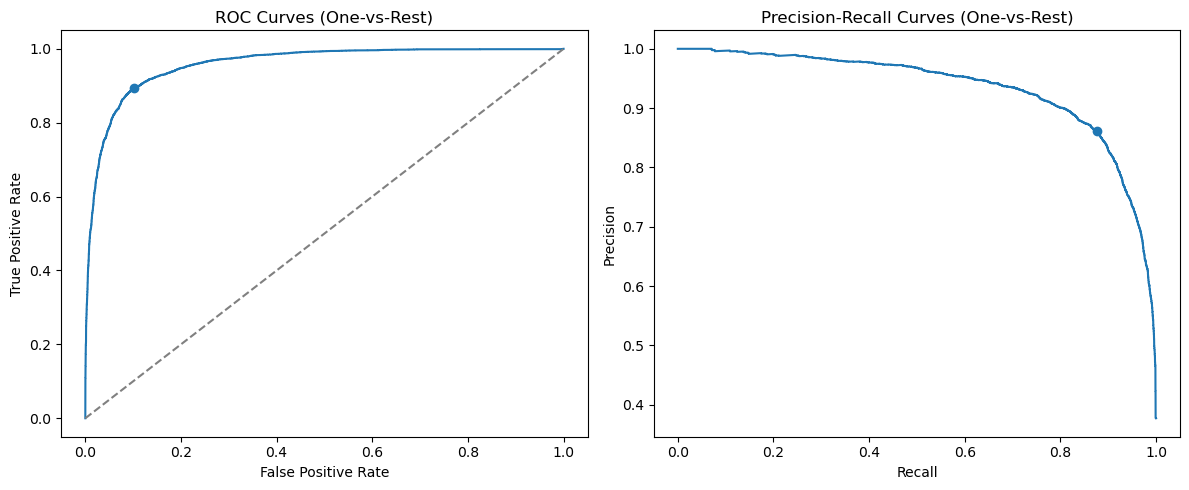


Classification Report (Thresholds from ROC):
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     10363
           1       0.84      0.89      0.87      6273

    accuracy                           0.90     16636
   macro avg       0.89      0.90      0.89     16636
weighted avg       0.90      0.90      0.90     16636


Classification Report (Thresholds from PR Curve):
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     10363
           1       0.86      0.88      0.87      6273

    accuracy                           0.90     16636
   macro avg       0.89      0.89      0.89     16636
weighted avg       0.90      0.90      0.90     16636



In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score

# Compute probabilities (again, if needed) and set number of classes (binary case: 1)
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
num_classes = 1
optimal_thresholds_roc = np.zeros(num_classes)
optimal_thresholds_pr = np.zeros(num_classes)

plt.figure(figsize=(12, 5))

# For each class, compute ROC and Precision-Recall curves and find optimal thresholds
for class_idx in range(num_classes):
    class_labels = labels_array[:, class_idx]  # Binary labels
    fpr, tpr, roc_thresholds = roc_curve(class_labels, probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    
    # Youden’s J statistic to find optimal ROC threshold
    youden_j = tpr - fpr
    optimal_idx_roc = np.argmax(youden_j)
    optimal_thresholds_roc[class_idx] = roc_thresholds[optimal_idx_roc]
    
    precision, recall, pr_thresholds = precision_recall_curve(class_labels, probs[:, class_idx])
    pr_auc = auc(recall, precision)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx_pr = np.argmax(f1_scores)
    optimal_thresholds_pr[class_idx] = pr_thresholds[optimal_idx_pr]
    
    # Plot ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], 
                label=f'Class {class_idx} Thresh = {optimal_thresholds_roc[class_idx]:.3f}')
    
    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'Class {class_idx} (AUC = {pr_auc:.2f})')
    plt.scatter(recall[optimal_idx_pr], precision[optimal_idx_pr],
                label=f'Class {class_idx} Thresh = {optimal_thresholds_pr[class_idx]:.3f}')

# Format ROC plot
plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')

# Format Precision-Recall plot
plt.subplot(1, 2, 2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (One-vs-Rest)')

plt.tight_layout()
plt.show()

# Apply ROC-based thresholds
preds = (probs > optimal_thresholds_roc).astype(int)
y_true = labels_array.astype(int)
y_pred = preds.astype(int)
print("\nClassification Report (Thresholds from ROC):")
print(classification_report(y_true, y_pred))

# Alternatively, apply PR-based thresholds
preds_pr = (probs > optimal_thresholds_pr).astype(int)
y_pred_pr = preds_pr.astype(int)
print("\nClassification Report (Thresholds from PR Curve):")
print(classification_report(y_true, y_pred_pr))